In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import sklearn as sk
import scipy as sp
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.linear_model import LogisticRegression

import re

from nltk.sentiment.vader import SentimentIntensityAnalyzer as SIA
import nltk
# nltk.download('vader_lexicon')

# Data processing

In [2]:
data = pd.read_csv('C:/Users/Drtong/Desktop/ML project/Combined_News_DJIA.csv')
print(data.shape)

# from nltk.stem.snowball import SnowballStemmer
# stemmer = SnowballStemmer("english",ignore_stopwords=True)
# for i in range (data.shape[0]):
#     for j in range (1,data.shape[1]):
#         temp=data.iloc[i,j]
#         if type(temp)!=str:
#             continue
#         temp= re.sub(r'[?|$|.|!]','',temp[2:-1])
#         temp=re.sub(r'[^A-Za-z$]{2,}', ' ', temp)
#         data.iloc[i,j]=" ".join([stemmer.stem(k) for k in temp.split()])
        
# train = data[data['Date'] < '2015-01-01']
# test = data[data['Date'] > '2014-12-31']

(1989, 27)


## Use sentiment lexicon to create sentiment score

In [3]:
sentiment=np.zeros((data.shape[0],data.shape[1]-2))
sia=SIA()
for i in range (data.shape[0]):
    for j in range (2,data.shape[1]):
        temp=data.iloc[i,j]
        if type(temp)!=str:
            sentiment[i,j-2]=None
            continue
        temp=re.sub(r'[?|$|.|!]','',temp[2:-1])
        sentiment[i,j-2]=sia.polarity_scores(temp)['compound']

## distribution of sentiment score

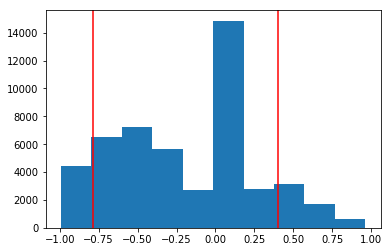

In [4]:
temp=sentiment.reshape((data.shape[0]*(data.shape[1]-2),1))
temp=temp[~np.isnan(temp)]
plt.hist(temp)
plt.axvline(x=np.percentile(temp,90),color='red')
plt.axvline(x=np.percentile(temp,10),color='red')
plt.show()

## leave out the close to neutral headlines

In [5]:
upper=np.nanpercentile(sentiment,90)
lower=np.nanpercentile(sentiment,10)
x=np.zeros((data.shape[0],3))
for i in range (data.shape[0]):
    temp=sentiment[i]
    x[i,0]=np.sum(sentiment[i]>upper)
    x[i,1]=np.sum(sentiment[i]<lower)
    x[i,2]=x[i,0]-x[i,1]

In [37]:
idx=(np.abs(x[:,2])==0)
x_adj=x[~idx]
data_adj=data[~idx]
x_adj.shape

(1578, 3)

# Fit a logistic regression model

In [33]:
x_train=x_adj[data_adj['Date'] < '2015-01-01',2]
x_train=x_train.reshape((x_train.shape[0],1))
x_test=x_adj[data_adj['Date'] > '2014-12-31',2]
x_test=x_test.reshape((x_test.shape[0],1))
y_train=data_adj[data_adj['Date'] < '2015-01-01']['Label']
y_test=data_adj[data_adj['Date'] > '2014-12-31']['Label']

In [34]:
from sklearn.linear_model import LogisticRegression
lm_fit= LogisticRegression()
lm_fit.fit(x_train,y_train)
y_estimate=lm_fit.predict(x_train)
y_predict = lm_fit.predict(x_test)
mis=np.mean(y_estimate!=y_train)
lm_mis=np.mean(y_predict!=y_test)
print("training error is %s, testing error is %s"%(mis, lm_mis))

training error is 0.4685802948021722, testing error is 0.4809688581314879


In [35]:
prob_predict=lm_fit.predict_proba(x_test)[:,1]

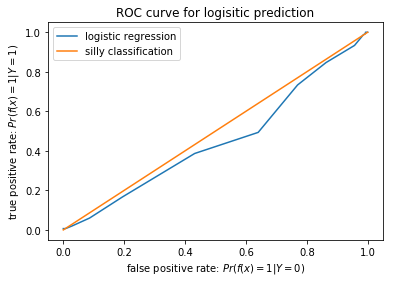

In [36]:
fpr, tpr, _=sk.metrics.roc_curve(y_test, prob_predict)
plt.plot(fpr,tpr,"-")
plt.plot(fpr,fpr,"-")
plt.xlabel("false positive rate: $Pr(f(x)=1|Y=0)$")
plt.ylabel("true positive rate: $Pr(f(x)=1|Y=1)$")
plt.title("ROC curve for logisitic prediction")
plt.legend(["logistic regression","silly classification"])